In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [114]:
# Importing the dataset
data = pd.read_csv('/Users/madisonchristiansen/Desktop/df.csv')   
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [116]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [117]:
# Preprocessing data - checking dataset for missing values 
data.isnull().sum().sort_values(ascending=False)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [124]:
# Preprocessing data - drop
data = data.drop(['step', 'nameOrig', 'isFlaggedFraud', 'nameDest'], axis=1)

In [125]:
# Preprocessing data
{column: len(data[column].unique()) for column in data.columns}

{'type': 5,
 'amount': 5316900,
 'oldbalanceOrg': 1845844,
 'newbalanceOrig': 2682586,
 'oldbalanceDest': 3614697,
 'newbalanceDest': 3555499,
 'isFraud': 2}

In [126]:
# Preprocessing data
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [127]:
# Preprocessing data - dummy variables 
pd.get_dummies(data['type'], prefix='tp')

,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
6362615,0,1,0,0,0
6362616,0,0,0,0,1
6362617,0,1,0,0,0
6362618,0,0,0,0,1


In [128]:
data

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


In [130]:
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

## one-hot encoding
encoder = OneHotEncoder(sparse=False, drop='first')
type_encoded = encoder.fit_transform(X[['type']])
type_columns = encoder.get_feature_names(['type'])
X = pd.concat([X.drop(['type'], axis=1), pd.DataFrame(type_encoded, columns=type_columns)], axis=1)## replace the 'type' column 

/Users/madisonchristiansen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [131]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing - standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [132]:
# Imbalanced-learn pipeline
## random oversampling and the Random Forest classifier
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy=0.5, random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

In [133]:
## train the model using the pipeline
pipeline.fit(X_train, y_train)

## predictions 
y_pred = pipeline.predict(X_test)

In [134]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

In [142]:
# Evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.9997092392756443
Precision: 0.9245923913043478
Recall: 0.8401234567901235
F1 Score: 0.8803363518758085
ROC AUC: 0.9965048955043412


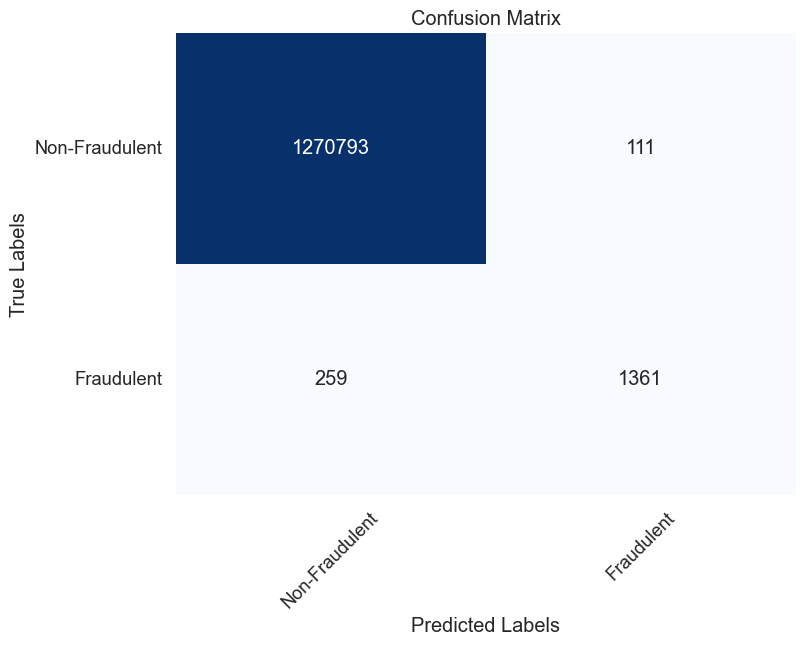

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have already calculated the confusion matrix
# Replace 'conf_matrix' with your actual confusion matrix

# Define class labels
class_labels = ['Non-Fraudulent', 'Fraudulent']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()